In [40]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,precision_score

In [4]:
wastageDF = pd.read_csv('./data/food_wastage_data.csv')

In [5]:
wastageDF.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

In [6]:
wastageDF.head()

,type_of_food,number_of_guests,event_type,quantity_of_food,storage_conditions,purchase_history,seasonality,preparation_method,geographical_location,pricing,wastage_food_amount
0,Meat,310,Corporate,450,Refrigerated,Regular,All Seasons,Buffet,Urban,Low,25
1,Meat,400,Birthday,500,Room Temperature,Regular,Winter,Buffet,Suburban,High,40
2,Vegetables,302,Birthday,371,Refrigerated,Regular,Summer,Buffet,Suburban,Low,27
3,Meat,491,Birthday,497,Refrigerated,Regular,All Seasons,Finger Food,Rural,High,32
4,Meat,300,Corporate,400,Refrigerated,Regular,Winter,Finger Food,Urban,Moderate,25


In [7]:
wastageDF.shape

(1782, 11)

In [8]:
wastageDF.columns

Index(['type_of_food', 'number_of_guests', 'event_type', 'quantity_of_food',
       'storage_conditions', 'purchase_history', 'seasonality',
       'preparation_method', 'geographical_location', 'pricing',
       'wastage_food_amount'],
      dtype='object')

In [9]:
# one hot encoding
columns_to_encode = ['type_of_food', 'event_type', 'storage_conditions', 'purchase_history', 'seasonality', 'preparation_method', 'geographical_location', 'pricing']

df_enc = pd.get_dummies(wastageDF, columns = columns_to_encode)
df_enc.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

In [10]:
df_enc.head(5)

,number_of_guests,quantity_of_food,wastage_food_amount,type_of_food_baked_goods,type_of_food_dairy_products,type_of_food_fruits,type_of_food_meat,type_of_food_vegetables,event_type_birthday,event_type_corporate,...,seasonality_winter,preparation_method_buffet,preparation_method_finger_food,preparation_method_sit-down_dinner,geographical_location_rural,geographical_location_suburban,geographical_location_urban,pricing_high,pricing_low,pricing_moderate
0,310,450,25,False,False,False,True,False,False,True,...,False,True,False,False,False,False,True,False,True,False
1,400,500,40,False,False,False,True,False,True,False,...,True,True,False,False,False,True,False,True,False,False
2,302,371,27,False,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,True,False
3,491,497,32,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,True,False,False
4,300,400,25,False,False,False,True,False,False,True,...,True,False,True,False,False,False,True,False,False,True


In [11]:
df_enc.dtypes

number_of_guests                       int64
quantity_of_food                       int64
wastage_food_amount                    int64
type_of_food_baked_goods                bool
type_of_food_dairy_products             bool
type_of_food_fruits                     bool
type_of_food_meat                       bool
type_of_food_vegetables                 bool
event_type_birthday                     bool
event_type_corporate                    bool
event_type_social_gathering             bool
event_type_wedding                      bool
storage_conditions_refrigerated         bool
storage_conditions_room_temperature     bool
purchase_history_occasional             bool
purchase_history_regular                bool
seasonality_all_seasons                 bool
seasonality_summer                      bool
seasonality_winter                      bool
preparation_method_buffet               bool
preparation_method_finger_food          bool
preparation_method_sit-down_dinner      bool
geographic

In [12]:
df_enc = df_enc.astype({col: int for col in df_enc.select_dtypes(include='bool').columns})

<Axes: >

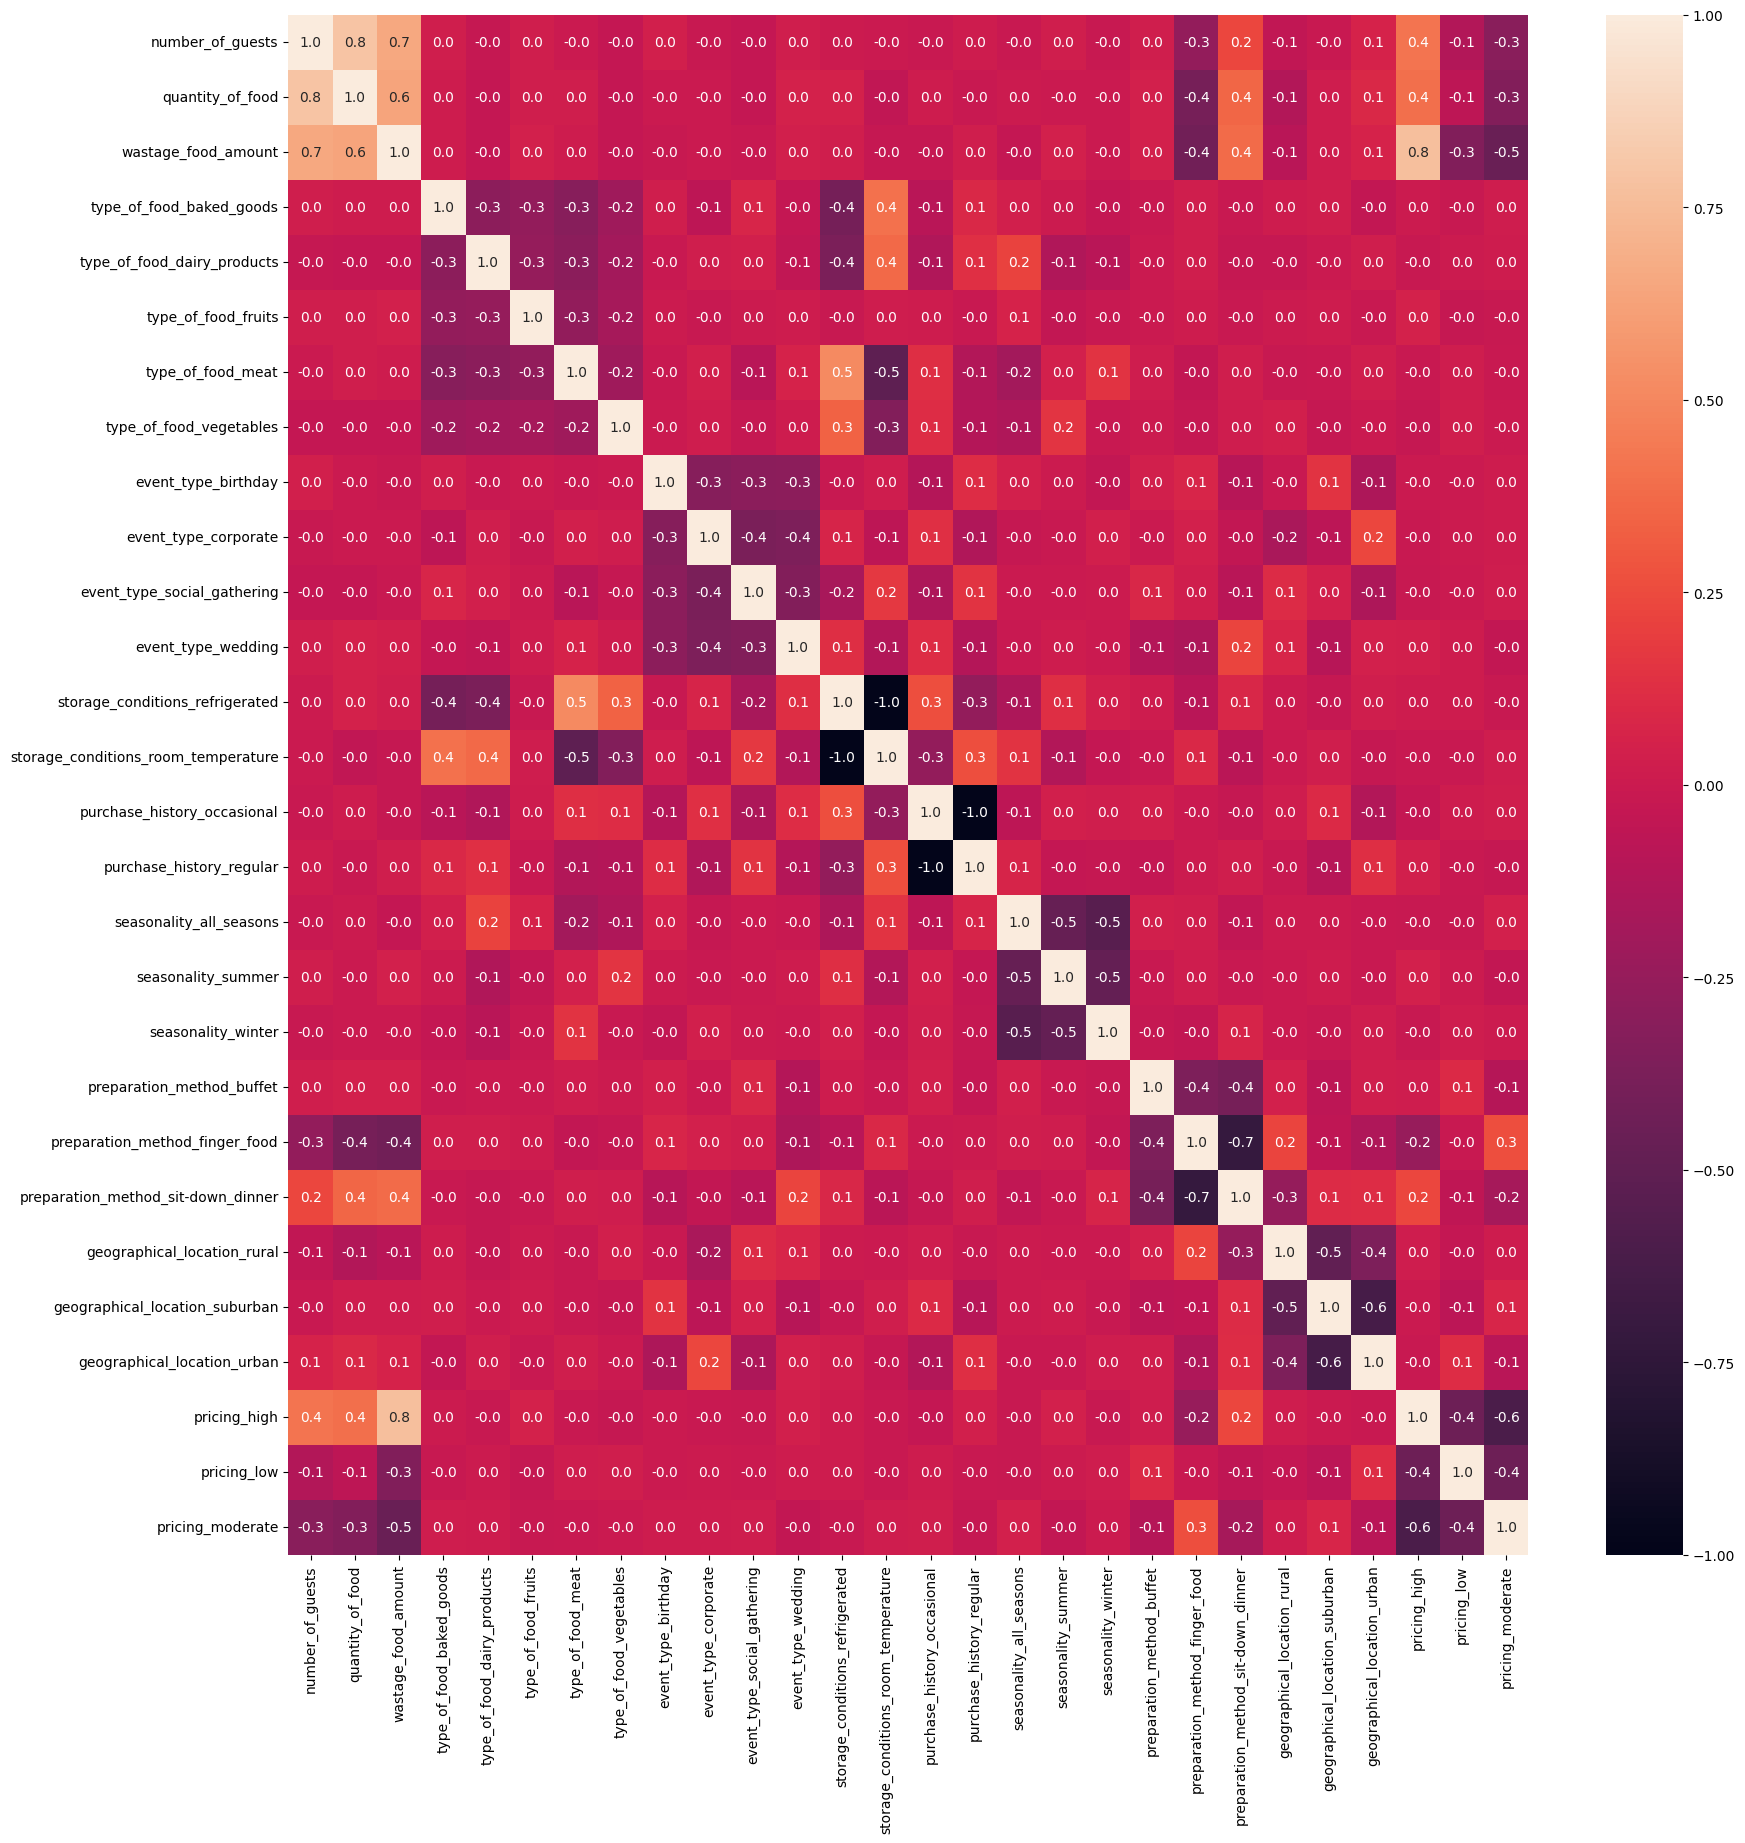

In [13]:
plt.figure(figsize=(20, 20))  # Adjust the width and height as needed
sns.heatmap(df_enc.corr(), annot=True, fmt='.1f')

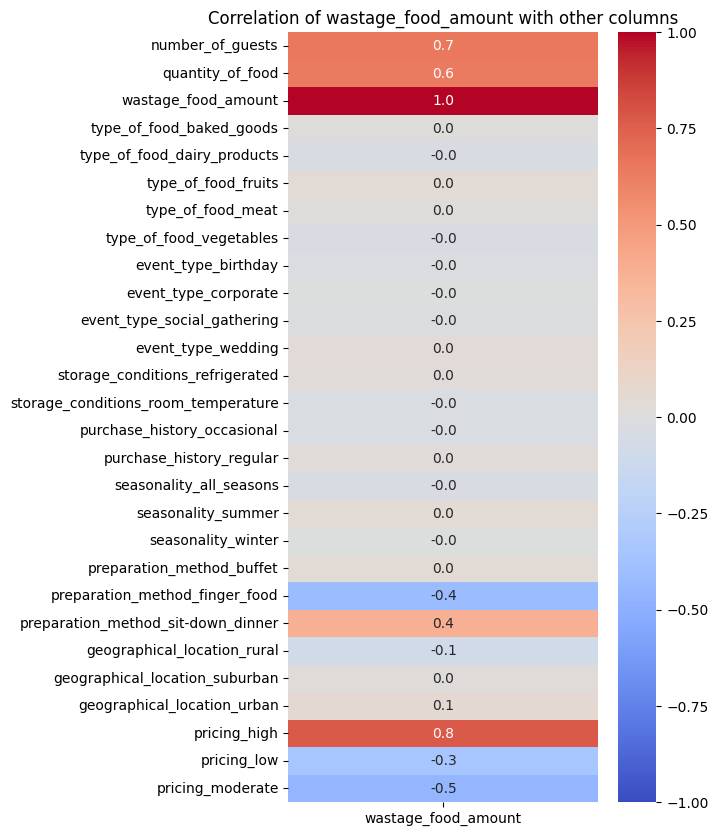

In [14]:
# Select the column for the heatmap
column_for_heatmap = 'wastage_food_amount'

# Compute the correlation of the selected column with all other columns
correlation = df_enc.corr()[[column_for_heatmap]]

# Plot heatmap
plt.figure(figsize=(5, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.1f')

plt.title(f'Correlation of {column_for_heatmap} with other columns')
plt.show()

In [15]:
correlation

,wastage_food_amount
number_of_guests,0.650421
quantity_of_food,0.638648
wastage_food_amount,1.000000
type_of_food_baked_goods,0.014578
type_of_food_dairy_products,-0.034436
type_of_food_fruits,0.042511
type_of_food_meat,0.008675
type_of_food_vegetables,-0.037732
event_type_birthday,-0.018613
event_type_corporate,-0.004177


In [18]:
df_enc['pricing_low'].value_counts()

pricing_low
0    1347
1     435
Name: count, dtype: int64

In [16]:
df_enc[df_enc['pricing_moderate']==0]['wastage_food_amount'].describe()

count    1109.000000
mean       32.289450
std        11.054676
min        10.000000
25%        24.000000
50%        35.000000
75%        40.000000
max        63.000000
Name: wastage_food_amount, dtype: float64

Modeling

In [17]:
df_enc_copy = df_enc.copy(deep = True)

In [18]:
y = df_enc_copy['wastage_food_amount']
df_enc_copy.drop(columns = ['wastage_food_amount'], inplace = True)
X = df_enc_copy

In [19]:
# Save the columns order for future use in the API
joblib.dump(X.columns, '../api/model/X_columns.pkl')

['../api/model/X_columns.pkl']

In [37]:
# Round target variable for illustrative precision calculation
y_rounded = np.round(y).astype(int)

In [50]:
feature_names = [f'Feature {i+1}' for i in range(X.shape[1])]
feature_names

['Feature 1',
 'Feature 2',
 'Feature 3',
 'Feature 4',
 'Feature 5',
 'Feature 6',
 'Feature 7',
 'Feature 8',
 'Feature 9',
 'Feature 10',
 'Feature 11',
 'Feature 12',
 'Feature 13',
 'Feature 14',
 'Feature 15',
 'Feature 16',
 'Feature 17',
 'Feature 18',
 'Feature 19',
 'Feature 20',
 'Feature 21',
 'Feature 22',
 'Feature 23',
 'Feature 24',
 'Feature 25',
 'Feature 26',
 'Feature 27']

In [41]:
# Split the data
X_train, X_test, y_train, y_test, y_train_rounded, y_test_rounded = train_test_split(X, y, y_rounded, test_size=0.2, random_state=42)

In [21]:
X.dtypes

number_of_guests                       int64
quantity_of_food                       int64
type_of_food_baked_goods               int64
type_of_food_dairy_products            int64
type_of_food_fruits                    int64
type_of_food_meat                      int64
type_of_food_vegetables                int64
event_type_birthday                    int64
event_type_corporate                   int64
event_type_social_gathering            int64
event_type_wedding                     int64
storage_conditions_refrigerated        int64
storage_conditions_room_temperature    int64
purchase_history_occasional            int64
purchase_history_regular               int64
seasonality_all_seasons                int64
seasonality_summer                     int64
seasonality_winter                     int64
preparation_method_buffet              int64
preparation_method_finger_food         int64
preparation_method_sit-down_dinner     int64
geographical_location_rural            int64
geographic

### List All model to test

In [22]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42),
    "XGBoost": xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=6),
    "LightGBM": lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100, max_depth=6)
}

In [42]:
# Function to evaluate model using RMSE, MSE, and precision
def evaluate_model(model, X_train, y_train, X_test, y_test, y_train_rounded, y_test_rounded):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_rounded = np.round(y_pred).astype(int)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    precision = precision_score(y_test_rounded, y_pred_rounded, average='micro')
    
    return rmse, mse, precision


### Low RMSE values show that the model makes more accurate predictions and fits the data well

In [43]:
# Evaluate all models
results = []
for name, model in models.items():
    rmse, mse, precision = evaluate_model(model, X_train, y_train, X_test, y_test, y_train_rounded, y_test_rounded)
    results.append({'Model': name, 'RMSE': rmse, 'MSE': mse, 'Precision': precision})

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1425, number of used features: 27
[LightGBM] [Info] Start training from score 28.708772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [44]:
# Display the table
results_df.head()

,Model,RMSE,MSE,Precision
0,Linear Regression,5.025579,25.256443,0.084034
1,Random Forest,3.159849,9.984649,0.254902
2,XGBoost,2.671548,7.137168,0.316527
3,LightGBM,2.970314,8.822767,0.254902


### Test XGBoost because it have lower score

In [27]:
# Hyperparameter tuning for the best model (example with XGBoost)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
Best RMSE: 2.909713099276532


### Fit and predict

In [29]:
# Fit The model
model.fit(X_train,y_train)
# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 1.9463162382109827
Mean Squared Error (MSE): 8.370267434784099
Root Mean Squared Error (RMSE): 2.893141447420796
R-squared (R^2): 0.9192509651184082


In [30]:
# Combine predictions and actual values for comparison
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

      Actual  Predicted
824       20  21.968521
1471      31  30.368267
233       20  19.751148
798       23  22.155245
777       20  18.962206
...      ...        ...
818       35  31.575470
532       20  18.462568
381       30  21.657337
844       40  41.537766
557       36  35.395592

[357 rows x 2 columns]


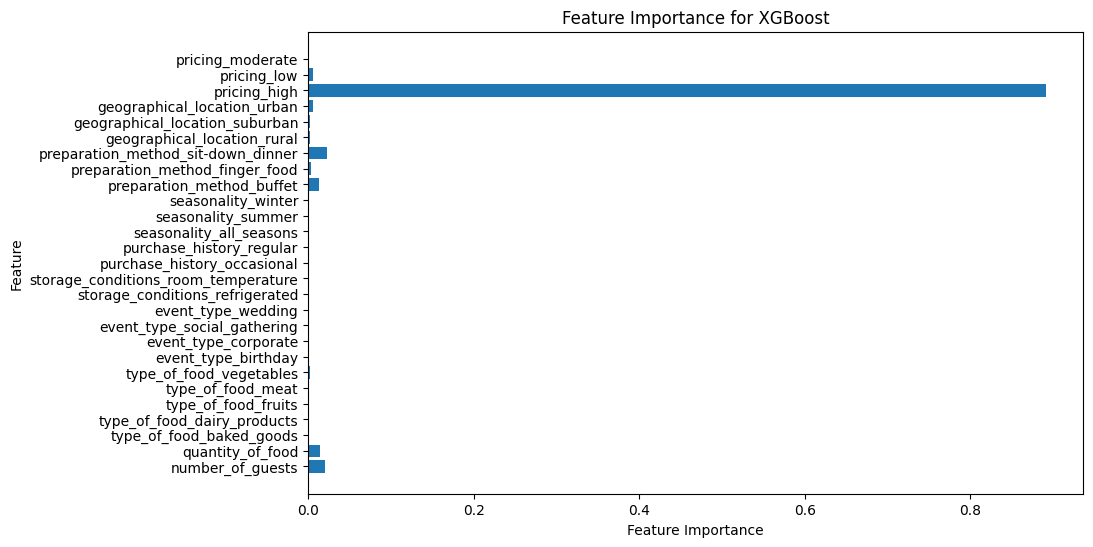

In [51]:
# Plot the feature importance for the best model (optional)
best_model_name = results_df.loc[results_df['RMSE'].idxmin()]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

if best_model_name in ["Random Forest", "LightGBM"]:
    importance = best_model.feature_importances_
elif best_model_name == "XGBoost":
    importance = best_model.feature_importances_
else:
    importance = best_model.coef_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance)
plt.yticks(range(len(importance)), X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for {best_model_name}')
plt.show()

In [37]:
import pickle

# Save the model to a pickle file
with open('../api/model/wastage_food_model_v1.pkl', 'wb') as file:
    pickle.dump(model, file)

In [39]:
y_pred

array([23.802616, 30.518774, 19.606176, 22.394367, 20.165691, 16.443588,
       19.633677, 41.81091 , 21.885946, 22.413393, 23.74586 , 31.190418,
       27.225637, 42.73948 , 22.066422, 19.415407, 15.249602, 10.414791,
       19.829464, 20.893444, 36.48433 , 16.39834 , 19.1239  , 39.150074,
       20.59075 , 26.85069 , 40.88619 , 18.033796, 40.136734, 32.45391 ,
       40.56313 , 34.80334 , 45.38937 , 15.165126, 19.679049, 15.249602,
       36.614056, 30.01125 , 36.09086 , 17.18241 , 45.883   , 24.492962,
       23.91386 , 15.667904, 15.64541 , 37.344437, 29.759491, 19.636143,
       20.447372, 19.063028, 31.507545, 37.5369  , 15.688953, 20.687956,
       37.488056, 30.27003 , 20.773354, 48.07315 , 16.196278, 15.085823,
       26.523516, 49.22243 , 18.85526 , 20.225964, 33.220787, 21.268862,
       34.727203, 22.608164, 15.281086, 33.688843, 23.91386 , 20.386644,
       19.72082 , 40.097107, 42.73948 , 39.893692, 21.486404, 36.20638 ,
       28.525057, 19.662462, 38.23604 , 19.2512  , 